# Week 8 - Instrumental Variables

This notebook uses an instrumental variable approach to estimate the returns from schooling, namely the effect of higher education on earnings. The reference paper for this notebook is [Angrist and Krueger (1991)](https://www.jstor.org/stable/2937954?seq=2#metadata_info_tab_contents).

To investigate this, we instrument education using the quarter of birth of individuals. This instrument relies on compulsory school attendance law. The idea behind it is that people born in the first 3 quarters can drop out of school one year earlier than those born in the last quarter.

In [3]:
# Common imports
import numpy as np
import os
import pandas as pd

# To plot pretty figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib notebook
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

df = pd.read_stata('data/ak91.dta')
pd.read_stata('data/ak91.dta', iterator=True).variable_labels()

{'AGE': '',
 'AGEQ': '',
 'EDUC': '',
 'ENOCENT': '',
 'ESOCENT': '',
 'LWKLYWGE': '',
 'MARRIED': '',
 'MIDATL': '',
 'MT': '',
 'NEWENG': '',
 'CENSUS': '',
 'QOB': '',
 'RACE': '',
 'SMSA': '',
 'SOATL': '',
 'WNOCENT': '',
 'WSOCENT': '',
 'YOB': '',
 'COHORT': '',
 'AGEQSQ': '',
 'YR20': '',
 'YR21': '',
 'YR22': '',
 'YR23': '',
 'YR24': '',
 'YR25': '',
 'YR26': '',
 'YR27': '',
 'YR28': '',
 'YR29': '',
 'QTR1': '',
 'QTR2': '',
 'QTR3': '',
 'QTR4': '',
 'random': ''}

In [4]:
df.head()

,AGE,AGEQ,EDUC,ENOCENT,ESOCENT,LWKLYWGE,MARRIED,MIDATL,MT,NEWENG,...,YR25,YR26,YR27,YR28,YR29,QTR1,QTR2,QTR3,QTR4,random
0,46,46.25,18,0,0,5.908553,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.227906e-08
1,45,45.25,11,0,0,5.464953,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.183647e-06
2,43,43.00,11,1,0,5.559889,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.024221e-06
3,42,42.00,16,0,0,5.790019,1,0,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.418815e-06
4,48,48.00,11,0,0,5.829240,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.485916e-06


For this part we will focus only on the 1940-1949 cohort. 

In [5]:
df['yob_q'] = df['YOB'] + (df['QOB']*0.25 - 0.25)


df40 = df.loc[df['COHORT']>39]
df40 = df40.loc[df['COHORT']<50]

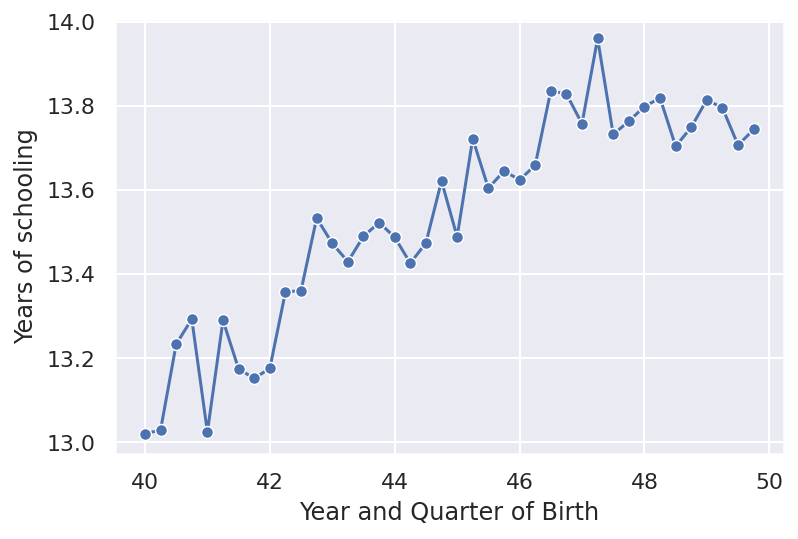

In [6]:
plot = sns.lineplot(data=df40, y='EDUC', x='yob_q', ci=None, marker='o')
plot.set(xlabel='Year and Quarter of Birth', ylabel='Years of schooling')
plt.show()

To have a better sense of the effect of being born in the last versus the first quarters of the year, we need to detrend the time series. 

In [7]:
df_avg = pd.DataFrame({'educ': df.groupby('yob_q')['EDUC'].mean()}).reset_index()
df_avg['ma_2'] = df_avg.educ.rolling(window=5, min_periods=5, center=True).sum().iloc[::1]
df_avg['ma_2'] = (df_avg['ma_2'] - df_avg['educ'])/4
df = df.merge(df_avg, how='left', on='yob_q')
df.head()

,AGE,AGEQ,EDUC,ENOCENT,ESOCENT,LWKLYWGE,MARRIED,MIDATL,MT,NEWENG,...,YR28,YR29,QTR1,QTR2,QTR3,QTR4,random,yob_q,educ,ma_2
0,46,46.25,18,0,0,5.908553,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,7.227906e-08,33.75,12.717438,12.655968
1,45,45.25,11,0,0,5.464953,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.183647e-06,1924.75,11.591770,11.523840
2,43,43.00,11,1,0,5.559889,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,2.024221e-06,1927.00,11.533557,11.574993
3,42,42.00,16,0,0,5.790019,1,0,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,2.418815e-06,38.00,12.949519,12.977089
4,48,48.00,11,0,0,5.829240,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.485916e-06,32.00,12.388527,12.682015


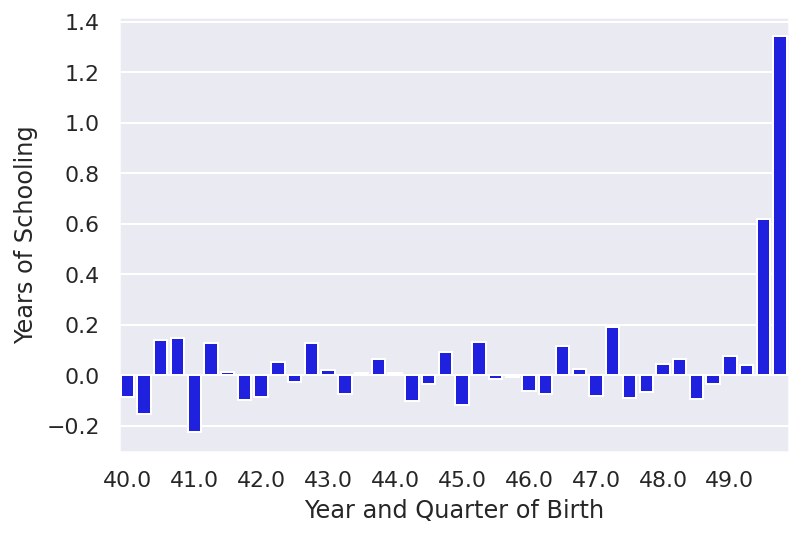

In [8]:
df['educ_std'] = df['educ'] - df['ma_2']
df40 = df.loc[df['COHORT']>39]
df40 = df40.loc[df['COHORT']<50]

plot = sns.barplot(x='yob_q', y='educ_std', data=df40, color='blue')
plot.set(xlabel='Year and Quarter of Birth', ylabel='Years of Schooling')
for ind, label in enumerate(plot.get_xticklabels()):
    if ind % 4 == 0: 
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.show()

## OLS

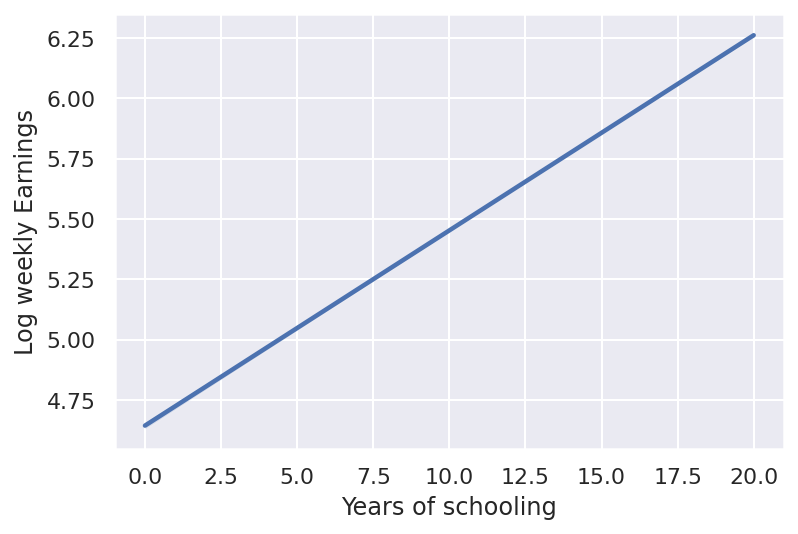

In [9]:
plot = sns.regplot(data=df, y='LWKLYWGE', x='EDUC', scatter=False, ci=95)
plot.set(ylabel='Log weekly Earnings', xlabel='Years of schooling')
plt.show()

In [10]:
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

df['index'] = df.index
df = df.set_index(["index", "YOB"])

exog_vars = ['EDUC']
exog = sm.add_constant(df[exog_vars])
ols = PanelOLS(df.LWKLYWGE, exog, entity_effects=False).fit(cov_type='robust')
print(ols)

                          PanelOLS Estimation Summary                           
Dep. Variable:               LWKLYWGE   R-squared:                        0.1369
Estimator:                   PanelOLS   R-squared (Between):              0.1369
No. Observations:              200000   R-squared (Within):               0.0000
Date:                Fri, Nov 19 2021   R-squared (Overall):              0.1369
Time:                        10:20:19   Log-likelihood                -2.019e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                   3.172e+04
Entities:                      200000   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                F(1,199998)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):          2.557e+04
                            

**What could be some OBSERVABLE confounders?**

Parent's wealth could affect both education and weekly earnings. Indeed, it is plausible to assume that individuals born into a richer family have access to both better education (e.g., can afford to go to better colleges) and to better jobs (e.g., through their parents' network), thus leading to an upward bias in the estimate.

In [13]:
from linearmodels.panel import compare

covs = ['NEWENG', 'MIDATL', 'ENOCENT', 'WNOCENT', 'SOATL', 'ESOCENT', 'WSOCENT', 'MT']
exog_vars = ['EDUC'] + covs
exog = sm.add_constant(df[exog_vars])
ols2 = PanelOLS(df.LWKLYWGE, exog, entity_effects=False).fit(cov_type='robust')
tfe = PanelOLS(df.LWKLYWGE, exog, entity_effects=False, time_effects=True).fit(cov_type='robust')

print(compare({"OLS": ols, "OLS Controls": ols2, "Time FE": tfe}, precision='std-errors'))

                        Model Comparison                       
                                  OLS OLS Controls      Time FE
---------------------------------------------------------------
Dep. Variable                LWKLYWGE     LWKLYWGE     LWKLYWGE
Estimator                    PanelOLS     PanelOLS     PanelOLS
No. Observations               200000       200000       200000
Cov. Est.                      Robust       Robust       Robust
R-squared                      0.1369       0.1427       0.1173
R-Squared (Within)             0.0000       0.0000       0.0000
R-Squared (Between)            0.1369       0.1427       0.1381
R-Squared (Overall)            0.1369       0.1427       0.1381
F-statistic                 3.172e+04       3697.8       2952.1
P-value (F-stat)               0.0000       0.0000       0.0000
=====================     ===========   ==========   ==========
const                          4.6432       4.6964       4.8951
                             (0.0068)   

**What could be some UNOBSERVED confounders? How can we account for these?**

Individuals' skills are one possible unobservable confounder to the estimate. For instance, individuals with more analytical skills could both perform better at school and attaining more education and perform better at work and get higher wages for this.

## IV Estimation

There are two equivalent ways to calculate the IV coefficient. Both methods rely on the following assumptions to be valid: 

1. Relevance
2. Exogeneity of the instrument
3. Exclusion restriction

The only *testable* assumption is relevance and we will focus on it below.

### Step 1. First Stage

Both procedures require the estimation of the *first stage*, which is the coefficient form a regression of the explanatory variable (education) on the instrument (quarter of birth). The regression is the following: 

$$Educ_i = \gamma_0 + \gamma_1 qob_i + \mathbf{X'}_i \delta + u_i$$

where $\mathbf{X'}_i$ is a vector of covariates. The first stage coefficients is $\gamma_1$.

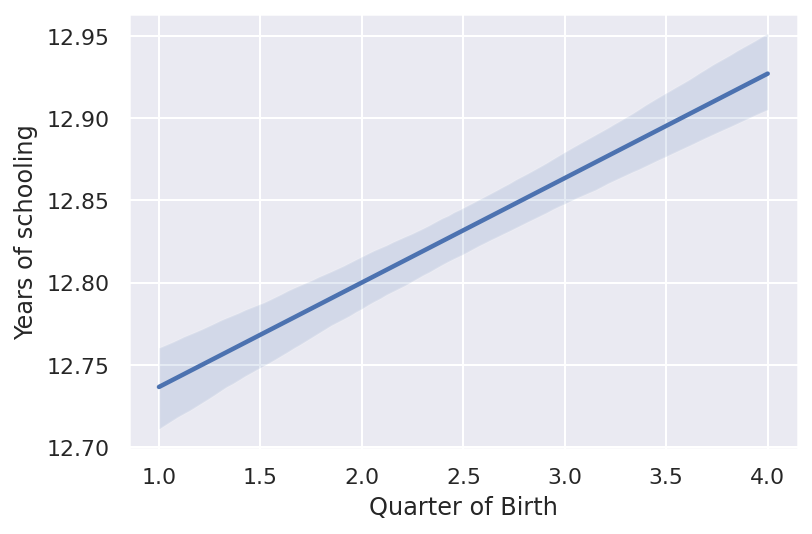

In [14]:
plot = sns.regplot(data=df, y='EDUC', x='QOB', scatter=False, ci=95)
plot.set(xlabel='Quarter of Birth', ylabel='Years of schooling')
plt.show()

In [15]:
exog_vars = ['QTR1', 'QTR2', 'QTR3']
exog = sm.add_constant(df[exog_vars])
fs = PanelOLS(df.EDUC, exog, entity_effects=False).fit(cov_type='robust')
exog_vars = ['QTR1', 'QTR2', 'QTR3'] + covs
exog = sm.add_constant(df[exog_vars])
fs2 = PanelOLS(df.EDUC, exog, entity_effects=False).fit(cov_type='robust')
fs_tfe = PanelOLS(df.EDUC, exog, entity_effects=False, time_effects=True).fit(cov_type='robust')


print(compare({"FS": fs, "FS Controls": fs2, "FS Time fe": fs_tfe}, precision='std-errors'))

                       Model Comparison                       
                                  FS  FS Controls   FS Time fe
--------------------------------------------------------------
Dep. Variable                   EDUC         EDUC         EDUC
Estimator                   PanelOLS     PanelOLS     PanelOLS
No. Observations              200000       200000       200000
Cov. Est.                     Robust       Robust       Robust
R-squared                     0.0005       0.0199       0.0221
R-Squared (Within)            0.0000       0.0000       0.0000
R-Squared (Between)           0.0005       0.0199       0.0196
R-Squared (Overall)           0.0005       0.0199       0.0196
F-statistic                   32.261       369.20       411.50
P-value (F-stat)              0.0000       0.0000       0.0000
=====================     ==========   ==========   ==========
const                         12.916       13.717       13.690
                            (0.0144)     (0.0225)     (

In [16]:
fs_coef = fs_tfe.params[1]

The validity of the IV approach relies on three main assumptions, on of which concerns the first stage. One requirement for the estimate to be valid is that of **relevance** of the instrument, known also as having a **strong first stage**. This means that the instrument must be strongly predictive of the explanatory variable, namely, the first stage coefficient must be significant and not small. 

**Does this assumption hold in this context? Focus mostly on the coefficient on being born in the first quarter.**

Our preferred specification is the last one, with controls and time fixed effects (FS Time fe). If we only focus on the coefficient on the dummy for being born in the first quarter of birth (*QTR1*), we can see that the coefficient is strongly statistically significant and different from zero, hinting that the relevance assumption is satisfied. However, the same cannot be said for the coefficient on being born in the third quarter of birth (*QTR3*). Therefore, since our set of instruments includes all 3 dummy variables, the proper test for the relevance assumption is a test for the joint significance of all the 3 coefficients in the last specification.

The test is performed below and the rule of thumb for the relevance assumption is that the F-stat (*statistic* in the results below) is lager than 10, which is the case here.

In [17]:
fs_tfe.wald_test(formula='QTR1=QTR2=QTR3=0')

Linear Equality Hypothesis Test
H0: Linear equality constraint is valid
Statistic: 73.0252
P-value: 0.0000
Distributed: chi2(3)
WaldTestStatistic, id: 0x7fc5fe0905e0

### Step 2a. Reduced Form

The first approach requires the estimation of the coefficient from a regression of the outcome variable on the instrument and the same covariates used in the first stage. 

$$lwklywge_i = \alpha_0 + \alpha_1 qob_i + \mathbf{X'}_i \delta + \varepsilon_i$$

The reduced form coefficient is $\alpha_1$.

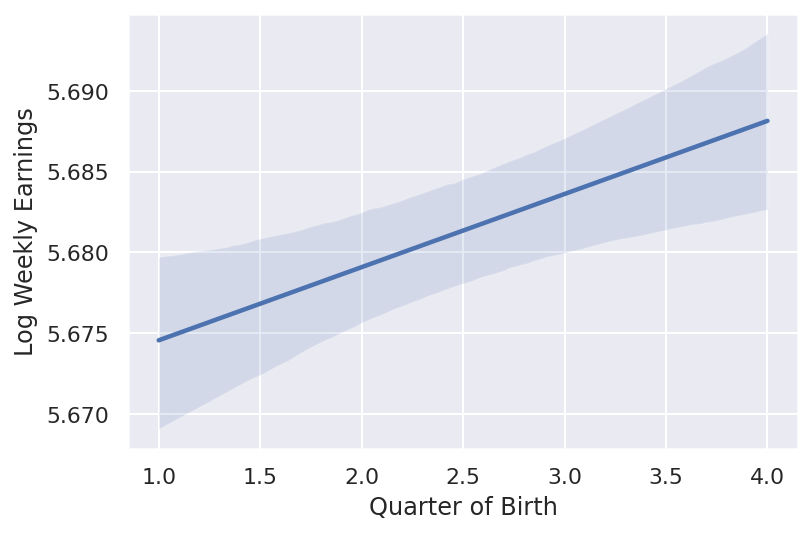

In [18]:
plot = sns.regplot(data=df, y='LWKLYWGE', x='QOB', scatter=False, ci=95)
plot.set(xlabel='Quarter of Birth', ylabel='Log Weekly Earnings')
plt.show()

In [25]:
exog_vars = ['QTR1', 'QTR2', 'QTR3']
exog = sm.add_constant(df[exog_vars])
rf = PanelOLS(df.LWKLYWGE, exog, entity_effects=False).fit(cov_type='robust')
exog_vars = ['QTR1', 'QTR2', 'QTR3'] + covs
exog = sm.add_constant(df[exog_vars])
rf2 = PanelOLS(df.LWKLYWGE, exog, entity_effects=False).fit(cov_type='robust')
rf_tfe = PanelOLS(df.LWKLYWGE, exog, entity_effects=False, time_effects=True).fit(cov_type='robust')

rf_coef = rf_tfe.params[1]
print(compare({"RF": rf, "RF Controls": rf2, "RF Time fe": rf_tfe}, precision='std-errors'))

                        Model Comparison                       
                                   RF  RF Controls   RF Time fe
---------------------------------------------------------------
Dep. Variable                LWKLYWGE     LWKLYWGE     LWKLYWGE
Estimator                    PanelOLS     PanelOLS     PanelOLS
No. Observations               200000       200000       200000
Cov. Est.                      Robust       Robust       Robust
R-squared                   6.595e-05       0.0116       0.0180
R-Squared (Within)             0.0000       0.0000       0.0000
R-Squared (Between)         6.595e-05       0.0116       0.0110
R-Squared (Overall)         6.595e-05       0.0116       0.0110
F-statistic                    4.3968       213.71       334.13
P-value (F-stat)               0.0042       0.0000       0.0000
=====================     ===========   ==========   ==========
const                          5.6853       5.7907       5.7898
                             (0.0032)   

**What can we say about the relationship between quarter of birth and earnings?**

The reduced form suggests that being born early in the year (*QTR1*, *QTR2* and *QTR3*) leads to have lower wages than being born in the last quarter.

### Step 3a. IV coefficient

Once we have the first stage and the reduced form coefficients, the IV coefficient is simply calculated by dividing the reduced form by the first stage: 

$$\beta_{IV} = \frac{\alpha_1}{\gamma_1}$$

**What do you expect on the sign of the relationship between education and wages?**

If we focus on the regressions, the coefficients on the dummies for being born in the first 3 quarters of the year are negative in both the first stage and the reduced form. This implies that if we take the ratio of the two the resulting coefficient will be positive, leading to a positive relationship between education and wages. 

The same can be inferred from the graphs. Indeed, quarter of birth is positively correlated with both education and earnings (recall that the coefficient from a regression of y on x is the slope of the fitted line). This suggests that the ratio between the coefficients of these two regression is positive.

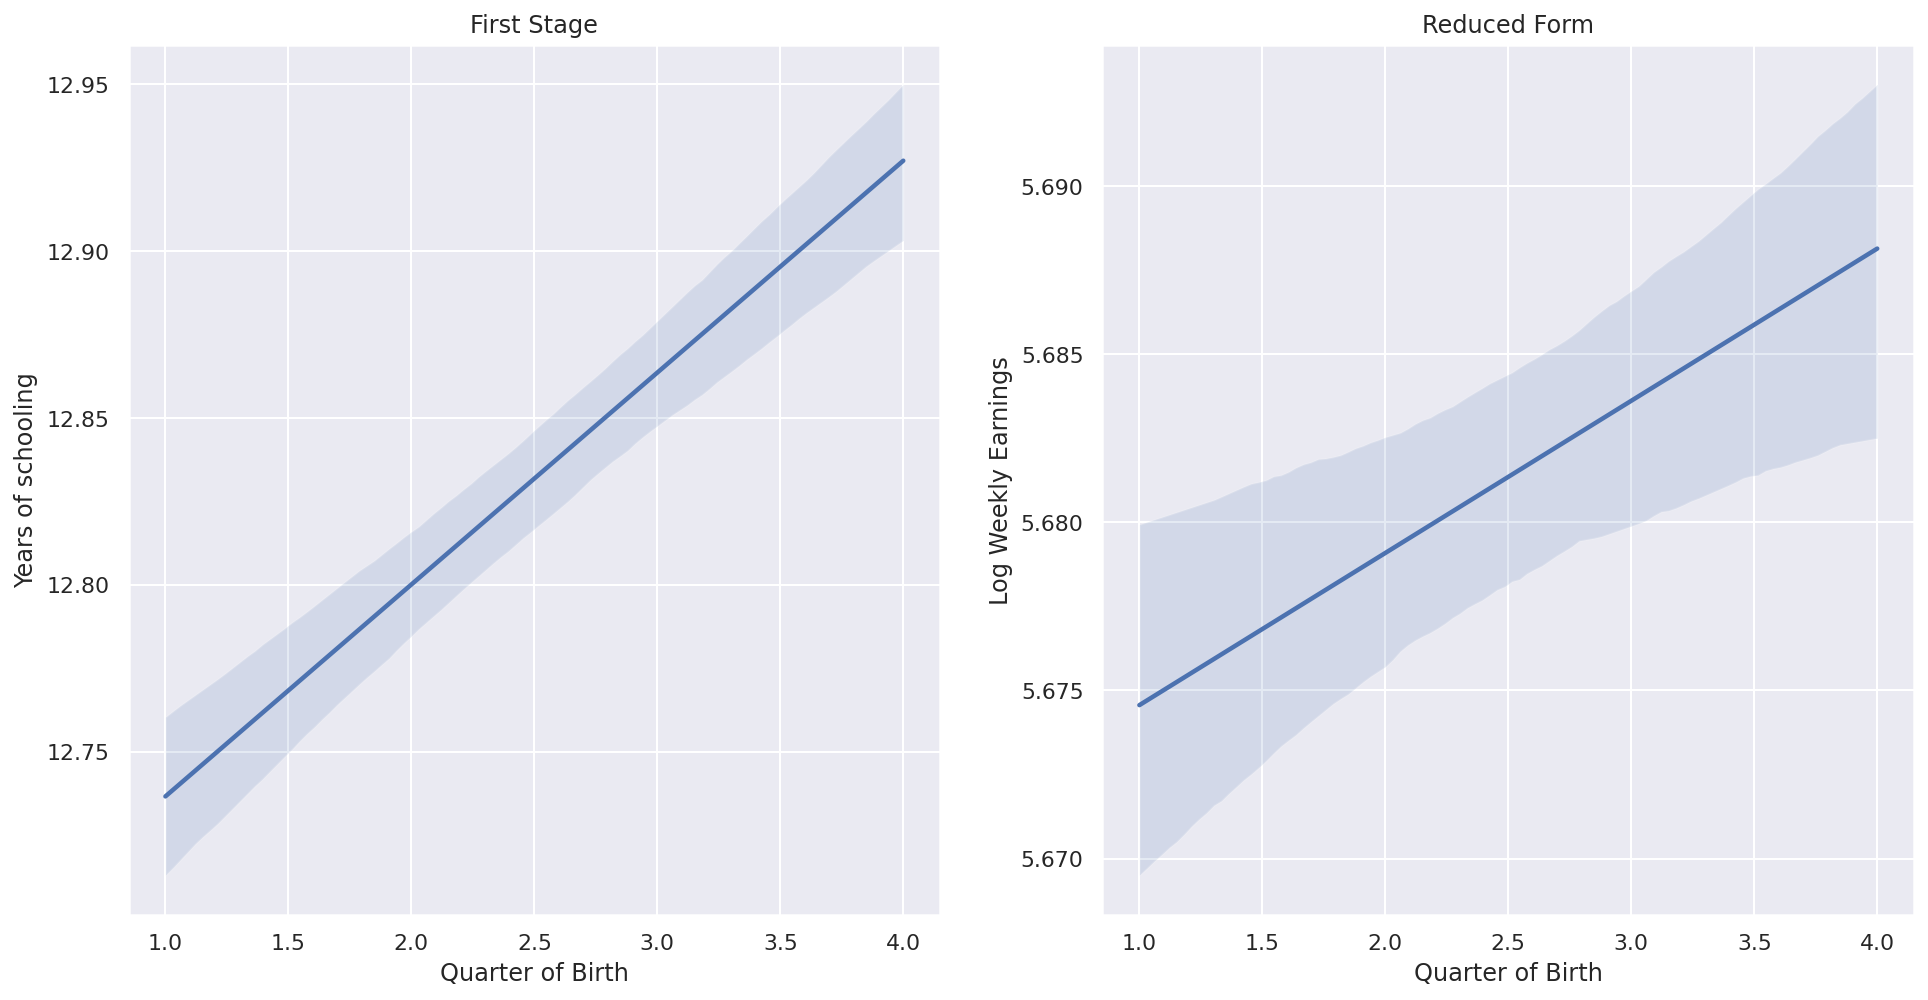

In [26]:
fig, ax = plt.subplots(1, 2,figsize=(16,8))

ax[0].set_title('First Stage')
sns.regplot(ax=ax[0], data=df, y='EDUC', x='QOB', scatter=False, ci=95)
ax[0].set(xlabel='Quarter of Birth', ylabel='Years of schooling')

ax[1].set_title('Reduced Form')
sns.regplot(ax=ax[1], data=df, y='LWKLYWGE', x='QOB', scatter=False, ci=95)
ax[1].set(xlabel='Quarter of Birth', ylabel='Log Weekly Earnings')
plt.show()

In [27]:
beta_iv = rf_coef/fs_coef
print(beta_iv)

0.035090437096080576


**Do you think that the exclusion restriction and the exogeneity assumptions are satisfied in this context?**

- The exogeneity assumption requires that the instrument is orthogonal to the error terms in both the first stage and the reduced form regression (i.e., there are no confounders that affect both the instrument and the explanatory variable or the outcome). This is equivalent to saying that the instrument is as good as randomly assigned. In this context, at first sight this might seem plausible. However, studies provided evidence that parents' wealth affects the period of the year their children are born and we already argued how parents' wealth can be correlated with both earnings and education. Since parents' wealth is not among our controls these considerations argue against the exogeneity assumption. 

- The exclusion restriction requires that the instrument affects the outcome only throuh the explanatory variable (i.e., there are no mediators between the instrument and the outcome, other than the explanatory variable). In this context this might again seem the case at first sight. However, other studies provided evidence that quarter of birth is correlated with health outcomes, like mental health, which in turn can affect earnings in other ways than through education. If this is the case then the exclusion restriction is violated.

## Two Stage Least Squares (2sls)

The second methodology to estimate the IV coefficient entails getting the predicted values from the first stage and running a regression of the outcome on these predicted values.

### Step 2b. Get FS predicted values


In [28]:
df['educ_hat1'] = fs.predict()
df['educ_hat2'] = fs2.predict()
df['educ_hat3'] = fs_tfe.predict()

df[['EDUC', 'educ_hat1', 'educ_hat2', 'educ_hat3']].head()

,,EDUC,educ_hat1,educ_hat2,educ_hat3
index,YOB,,,,
0,33,18,12.915621,13.327847,13.287455
1,1924,11,12.915621,13.016969,12.968385
2,1927,11,12.723182,12.550986,12.599027
3,38,16,12.723182,12.823083,12.807868
4,32,11,12.723182,12.327189,12.298748


### Step 3b. Regress the outcome on the predicted values

The regression is the following: 

$$lwklywge_i = \beta_0 + \beta_{2sls} \hat{EDUC}_i + \varepsilon_i$$

In [30]:
exog_vars = ['educ_hat1']
exog = sm.add_constant(df[exog_vars])
iv2sls = PanelOLS(df.LWKLYWGE, exog, entity_effects=False).fit(cov_type='robust')
exog_vars = ['educ_hat2']
exog = sm.add_constant(df[exog_vars])
iv2sls_2 = PanelOLS(df.LWKLYWGE, exog, entity_effects=False).fit(cov_type='robust')
exog_vars = ['educ_hat3']
exog = sm.add_constant(df[exog_vars])
iv2sls_3 = PanelOLS(df.LWKLYWGE, exog, entity_effects=False, time_effects=True).fit(cov_type='robust')

print(compare({"2SLS": iv2sls, "2SLS Controls": iv2sls_2, "2SLS Time fe": iv2sls_3}, precision='std-errors'))

                        Model Comparison                        
                                 2SLS 2SLS Controls 2SLS Time fe
----------------------------------------------------------------
Dep. Variable                LWKLYWGE      LWKLYWGE     LWKLYWGE
Estimator                    PanelOLS      PanelOLS     PanelOLS
No. Observations               200000        200000       200000
Cov. Est.                      Robust        Robust       Robust
R-squared                   5.336e-05        0.0067       0.0105
R-Squared (Within)             0.0000        0.0000       0.0000
R-Squared (Between)         5.336e-05        0.0067       0.0074
R-Squared (Overall)         5.336e-05        0.0067       0.0074
F-statistic                    10.672        1358.9       2125.5
P-value (F-stat)               0.0011        0.0000       0.0000
=====================     ===========    ==========   ==========
const                          4.7495        4.0475       3.8602
                         

**Interpretation of the coefficient:** Focusing on column 3, the coefficient on education suggests that an additional year of education leads to have weekly earnings higher by 14\%

## IV Estimation with linearmodels

In [31]:
from linearmodels.iv import IV2SLS

iv_set = df[['QTR1', 'QTR2', 'QTR3']]
exog = sm.add_constant(df[covs])
iv = IV2SLS(df.LWKLYWGE, exog, df.EDUC, iv_set).fit(cov_type='robust')

print(iv)

                          IV-2SLS Estimation Summary                          
Dep. Variable:               LWKLYWGE   R-squared:                      0.1421
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1421
No. Observations:              200000   F-statistic:                    2625.4
Date:                Fri, Nov 19 2021   P-value (F-stat)                0.0000
Time:                        11:05:50   Distribution:                  chi2(9)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          4.7651     0.2785     17.108     0.0000      4.2192      5.3111
NEWENG        -0.0530     0.0108    -4.9210     0.00